# Phase 01 · Data Exploration

## Dataset Goal & Source
- **Goal:** explore Saudi Professional League (SPL) match data to understand scoring patterns, venue effects, and match outcomes as preparation for building predictive and recommendation models.
- **Use Case:** informs advice/action-suggestion systems for football analysts (e.g., lineup guidance, opponent scouting, match outcome prediction).
- **Source:** [Saudi Professional League Datasets](https://github.com/alitif/Saudi-Professional-League-Datasets) collected from FlashScore (FS) and SLSTAT (SS) feeds.

In [1]:
# Core analysis stack
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", palette="deep")

In [2]:
# Load normalized SPL dataset
data_path = Path("Dataset") / "SPL_raw_normalized.csv"
df = pd.read_csv(data_path)
df.head()

,match_id,date,time,home_team,away_team,home_score,away_score,stadium,city,round,referee_name,attendance,season_label,season_start_year,season_end_year,stage,source_file
0,1.0,02.11.2000,20:00,Al-Ettifaq,Al Riyadh,1.0,0.0,NaN,NaN,NaN,NaN,NaN,2000-2001,2000,2001,FS,SPL-2000-2001-FS.csv
1,2.0,02.11.2000,20:00,Al Najma,Al-Nassr,0.0,1.0,NaN,NaN,NaN,NaN,NaN,2000-2001,2000,2001,FS,SPL-2000-2001-FS.csv
2,3.0,03.11.2000,20:00,Al Ahli SC,Al Ansar,3.0,0.0,NaN,NaN,NaN,NaN,NaN,2000-2001,2000,2001,FS,SPL-2000-2001-FS.csv
3,4.0,07.11.2000,20:00,Al Qadisiya,Sdoos,0.0,3.0,NaN,NaN,NaN,NaN,NaN,2000-2001,2000,2001,FS,SPL-2000-2001-FS.csv
4,5.0,08.11.2000,20:00,Al Wehda,Al-Shabab,1.0,0.0,NaN,NaN,NaN,NaN,NaN,2000-2001,2000,2001,FS,SPL-2000-2001-FS.csv


## General Information
We inspect the dataset size, feature types, and define the target variable used throughout the course phases. For modeling we derive a categorical outcome based on home/away goals.

In [3]:
num_rows, num_cols = df.shape
print(f"Observations: {num_rows:,}\nFeatures: {num_cols}")
df.dtypes.sort_index()

Observations: 3,260
Features: 17


attendance           float64
away_score           float64
away_team             object
city                  object
date                  object
home_score           float64
home_team             object
match_id             float64
referee_name          object
round                 object
season_end_year        int64
season_label          object
season_start_year      int64
source_file           object
stadium               object
stage                 object
time                  object
dtype: object

**Target variable:** We derive `match_outcome` (Home Win, Draw, Away Win) from `home_score` and `away_score`. Continuous features include goal counts and attendance; categorical features capture venue, city, round, and season metadata.

## Summary & Visualizations
We explore statistical summaries, missing data patterns, and class balance for the derived outcome.

In [4]:
numeric_cols = ["home_score", "away_score", "attendance", "season_start_year", "season_end_year"]
summary_stats = df[numeric_cols].apply(pd.to_numeric, errors="coerce").describe().T
summary_stats

,count,mean,std,min,25%,50%,75%,max
home_score,3257.0,1.567393,1.345373,0.0,1.0,1.0,2.0,10.0
away_score,3257.0,1.337120,1.185478,0.0,0.0,1.0,2.0,8.0
attendance,182.0,4204.186813,4595.983854,6.0,629.0,2611.5,6582.0,21174.0
season_start_year,3260.0,2009.173620,4.842019,2000.0,2006.0,2010.0,2013.0,2017.0
season_end_year,3260.0,2010.173620,4.842019,2001.0,2007.0,2011.0,2014.0,2018.0


In [5]:
missing_counts = df.replace('', pd.NA).isna().sum().sort_values(ascending=False)
missing_counts[missing_counts > 0]

attendance      3078
referee_name    2812
stadium         2812
city            2812
round           1218
match_id           3
away_team          3
date               3
time               3
home_score         3
away_score         3
home_team          3
dtype: int64

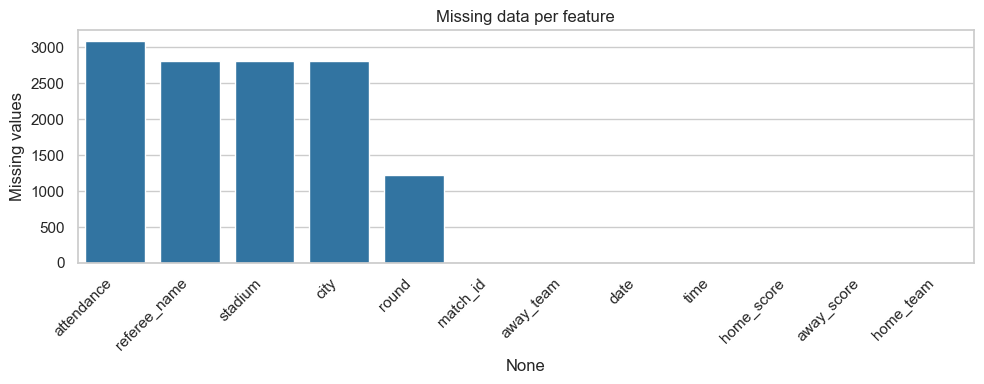

In [6]:
plt.figure(figsize=(10, 4))
sns.barplot(x=missing_counts[missing_counts > 0].index, y=missing_counts[missing_counts > 0].values, color="tab:blue")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Missing values")
plt.title("Missing data per feature")
plt.tight_layout()

In [7]:
def derive_outcome(row):
    try:
        hs = int(row["home_score"])
        as_ = int(row["away_score"])
    except (TypeError, ValueError):
        return pd.NA
    if pd.isna(hs) or pd.isna(as_):
        return pd.NA
    if hs > as_:
        return "Home Win"
    if hs < as_:
        return "Away Win"
    return "Draw"

df["match_outcome"] = df.apply(derive_outcome, axis=1)
df["match_outcome"].value_counts(dropna=False)

match_outcome
Home Win    1395
Away Win    1039
Draw         823
<NA>           3
Name: count, dtype: int64

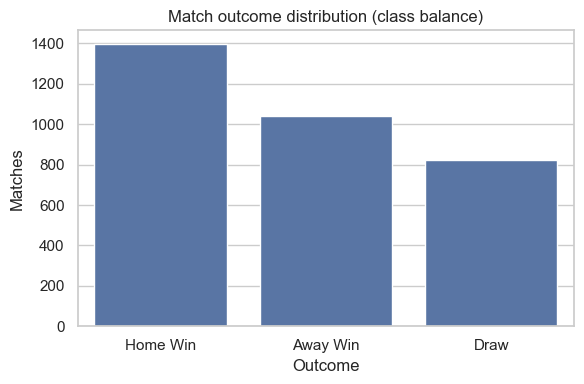

In [8]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="match_outcome", order=df["match_outcome"].value_counts().index)
plt.title("Match outcome distribution (class balance)")
plt.xlabel("Outcome")
plt.ylabel("Matches")
plt.tight_layout()

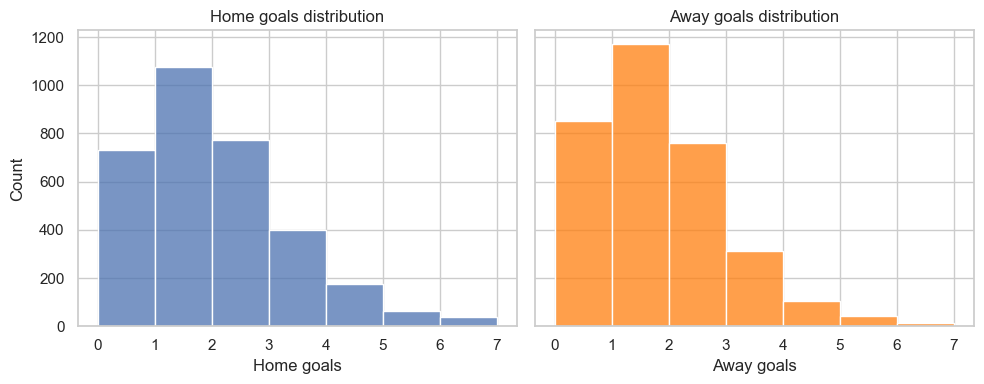

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
sns.histplot(df["home_score"].astype(float), bins=range(0, 8), ax=axes[0], kde=False)
axes[0].set_title("Home goals distribution")
axes[0].set_xlabel("Home goals")
sns.histplot(df["away_score"].astype(float), bins=range(0, 8), ax=axes[1], kde=False, color="tab:orange")
axes[1].set_title("Away goals distribution")
axes[1].set_xlabel("Away goals")
plt.tight_layout()

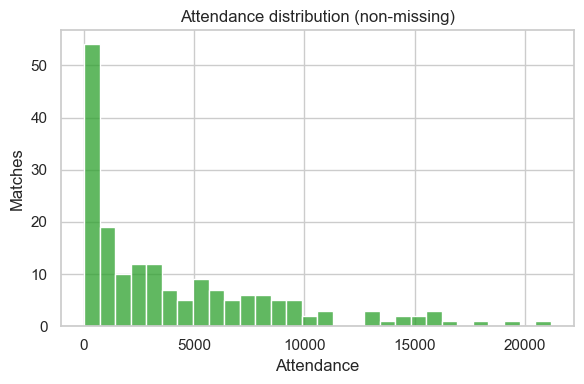

In [10]:
attendance_numeric = pd.to_numeric(df["attendance"], errors="coerce")
plt.figure(figsize=(6, 4))
sns.histplot(attendance_numeric.dropna(), bins=30, color="tab:green")
plt.title("Attendance distribution (non-missing)")
plt.xlabel("Attendance")
plt.ylabel("Matches")
plt.tight_layout()

## Preprocessing Techniques
Steps applied to prepare the dataset for modeling phases. Each step is justified to support feature quality and downstream learning.

In [11]:
processed_df = df.copy()

# 1. Normalize missing indicators by converting empty strings to NaN
processed_df = processed_df.replace('', pd.NA)

# 2. Convert date/time fields to datetime aware representations
processed_df["date"] = pd.to_datetime(processed_df["date"], format="%d.%m.%Y", errors="coerce")
processed_df["time"] = pd.to_datetime(processed_df["time"], format="%H:%M", errors="coerce").dt.time

# 3. Cast numeric metrics to integers/floats
for col in ["home_score", "away_score", "season_start_year", "season_end_year", "attendance"]:
    processed_df[col] = pd.to_numeric(processed_df[col], errors="coerce")

# 4. Derive match outcome encoding for classification experiments
processed_df["match_outcome"] = processed_df.apply(derive_outcome, axis=1)

# 5. Drop rows without scores (rare records without results)
processed_df = processed_df.dropna(subset=["home_score", "away_score", "match_outcome"]).reset_index(drop=True)

processed_df.head()

,match_id,date,time,home_team,away_team,home_score,away_score,stadium,city,round,referee_name,attendance,season_label,season_start_year,season_end_year,stage,source_file,match_outcome
0,1.0,2000-11-02,20:00:00,Al-Ettifaq,Al Riyadh,1.0,0.0,NaN,NaN,NaN,NaN,NaN,2000-2001,2000,2001,FS,SPL-2000-2001-FS.csv,Home Win
1,2.0,2000-11-02,20:00:00,Al Najma,Al-Nassr,0.0,1.0,NaN,NaN,NaN,NaN,NaN,2000-2001,2000,2001,FS,SPL-2000-2001-FS.csv,Away Win
2,3.0,2000-11-03,20:00:00,Al Ahli SC,Al Ansar,3.0,0.0,NaN,NaN,NaN,NaN,NaN,2000-2001,2000,2001,FS,SPL-2000-2001-FS.csv,Home Win
3,4.0,2000-11-07,20:00:00,Al Qadisiya,Sdoos,0.0,3.0,NaN,NaN,NaN,NaN,NaN,2000-2001,2000,2001,FS,SPL-2000-2001-FS.csv,Away Win
4,5.0,2000-11-08,20:00:00,Al Wehda,Al-Shabab,1.0,0.0,NaN,NaN,NaN,NaN,NaN,2000-2001,2000,2001,FS,SPL-2000-2001-FS.csv,Home Win


**Justification of preprocessing steps:**
- Replacing empty strings ensures pandas recognizes missing values for accurate imputation/analysis.
- Casting date/time enables chronological sorting and feature engineering (e.g., rest days).
- Numeric casting standardizes goals and attendance for statistical modeling and scaling.
- Derived `match_outcome` provides the classification target required in later phases.
- Dropping rows without scored results avoids leaking incomplete labels into training.

In [12]:
processed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3257 entries, 0 to 3256
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   match_id           3257 non-null   float64       
 1   date               2805 non-null   datetime64[ns]
 2   time               2809 non-null   object        
 3   home_team          3257 non-null   object        
 4   away_team          3257 non-null   object        
 5   home_score         3257 non-null   float64       
 6   away_score         3257 non-null   float64       
 7   stadium            448 non-null    object        
 8   city               448 non-null    object        
 9   round              2042 non-null   object        
 10  referee_name       448 non-null    object        
 11  attendance         182 non-null    float64       
 12  season_label       3257 non-null   object        
 13  season_start_year  3257 non-null   int64         
 14  season_e